In [1]:
#defining the input path
inputPath = "/data/students/bigdata_internet/lab4/log_tcp_complete_classes.txt"

In [2]:
#tried some ways to read but it was giving me only one column named Value
#csv format can handle different files and different delimeters
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").option("delimiter", " ").load(inputPath)

In [3]:
#viewing the col names and date structure
#printScema was a clean option

columns = df.columns
print(len(df.columns))
# df.printSchema()
# df.show()

207


### 1.1
##### Data has 207 columns/Features

## 1.2

In [4]:
#counting the tcp connecetions
df.select(df["con_t:42"]).distinct().count()

23/02/08 15:27:49 WARN util.Utils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


7

In [27]:
# +--------+
# |con_t:42|
# +--------+
# |       1|
# |   24576|
# |   16384|
# |  131072|
# |   16385|
# |    8192|
# |       0|
# +--------+

#### there are 7 different TCP Connection Types in the table

## 2.0.1
## 2.0.1

In [50]:
#counting distinct clases in dataset
df.select(df["class:207"]).distinct().count()

10

## 2.0.1
#### here is the complete list

In [ ]:
# +---------------+
# |      class:207|
# +---------------+
# |   class:google|
# |   class:amazon|
# |class:instagram|
# | class:facebook|
# |  class:netflix|
# |     class:ebay|
# |  class:spotify|
# | class:linkedin|
# |  class:youtube|
# |     class:bing|
# +---------------+

#### there are 10 different classes

## 2.0.3

In [5]:
#counting number of each one in their specific group
df.groupBy("class:207").agg({'*':'count'}).show()

+---------------+--------+
|      class:207|count(1)|
+---------------+--------+
|   class:google|   10000|
|   class:amazon|   10000|
|class:instagram|   10000|
| class:facebook|   10000|
|  class:netflix|   10000|
|     class:ebay|   10000|
|  class:spotify|   10000|
| class:linkedin|   10000|
|  class:youtube|   10000|
|     class:bing|   10000|
+---------------+--------+



##### there are 10000 connections per each we service

## 2.1.1
##### No, it is not a good item to be selected as a feature since it does not mean anything on the client side since the reuqest comming from the ip+port can be anything. but it maybe useful on the server side since we can undrestand the whole concept of the service.

## 2.1.2
##### No, it is not fair. since the web services are provideing their services with different servers with different ip addresses which all are known with their Domain.

# Selceting the features

In [6]:
#with reading the documents these features were the ones which made the most sense
selected_df = df.select("class:207","fqdn:127","c_pkts_all:3","s_pkts_all:17","c_bytes_uniq:7","s_bytes_uniq:21","con_t:42",\
                        "p2p_t:43","http_t:44","http_req_cnt:111", "http_res_cnt:112","c_pkts_data:8","s_pkts_data:22",\
                        "p2p_st:59")

In [8]:
# 762
#i chose fqdn then in the part of using random forest i got an error which fqdn is not a proper feature
# fqdn:127 -> 762 different numbers which doesn't work on random Forest
# selected_df.groupBy("p2p_t:43").agg({"*":"count"}).count()

In [9]:
import pyspark.ml
from pyspark.ml.feature import VectorAssembler, StringIndexer

# 2.3
### pre-process

In [10]:
# fitting the categorical columns onto dataset using StringIndexer
# it doesn't make sense to use these columns as they are since they will make problems in calculations

WSEncoder = StringIndexer(inputCol="class:207",outputCol="WebService").fit(selected_df)
# fqdnEncoder = StringIndexer(inputCol="fqdn:127",outputCol="fqdn").fit(selected_df)
ConEncoder = StringIndexer(inputCol="con_t:42",outputCol="con_t").fit(selected_df)
p2pncoder = StringIndexer(inputCol="p2p_t:43",outputCol="p2p_t").fit(selected_df)
HttpEncoder = StringIndexer(inputCol="http_t:44",outputCol="http_t").fit(selected_df)
p2p_st_Encoder = StringIndexer(inputCol="p2p_st:59",outputCol="p2p_st").fit(selected_df)

In [11]:
# using transformer to apply the learnt stuff into the dataset

transDF = WSEncoder.transform(selected_df)
# transDF = fqdnEncoder.transform(transDF)
transDF = ConEncoder.transform(transDF)
transDF = p2pncoder.transform(transDF)
transDF = HttpEncoder.transform(transDF)
transDF = p2p_st_Encoder.transform(transDF)

In [12]:
print(transDF.columns)

['class:207', 'fqdn:127', 'c_pkts_all:3', 's_pkts_all:17', 'c_bytes_uniq:7', 's_bytes_uniq:21', 'con_t:42', 'p2p_t:43', 'http_t:44', 'http_req_cnt:111', 'http_res_cnt:112', 'c_pkts_data:8', 's_pkts_data:22', 'p2p_st:59', 'WebService', 'con_t', 'p2p_t', 'http_t', 'p2p_st']


In [14]:
# after transformation we need to drop previous columns and select the one that are needed
start_df = transDF.select('c_pkts_all:3', 's_pkts_all:17', 'c_bytes_uniq:7', 's_bytes_uniq:21',\
                'http_req_cnt:111', 'http_res_cnt:112', 'c_pkts_data:8','s_pkts_data:22',\
                'con_t', 'p2p_t', 'http_t', 'p2p_st', 'WebService')

In [15]:
# making a list of features to use in the next step
required_features = ['c_pkts_all:3', 's_pkts_all:17', 'c_bytes_uniq:7', 's_bytes_uniq:21',\
                'http_req_cnt:111', 'http_res_cnt:112', 'c_pkts_data:8','s_pkts_data:22',\
                'con_t', 'p2p_t', 'http_t', 'p2p_st','WebService']

In [16]:
# using vector assembler to put the columns into a column called feature
# then using transformer to implement on the dataset
vec_assembler = VectorAssembler(inputCols=required_features, outputCol='features')
vec_df = vec_assembler.transform(start_df)

In [18]:
#final datatset structure/ columns
print(vec_df.columns)

['c_pkts_all:3', 's_pkts_all:17', 'c_bytes_uniq:7', 's_bytes_uniq:21', 'http_req_cnt:111', 'http_res_cnt:112', 'c_pkts_data:8', 's_pkts_data:22', 'con_t', 'p2p_t', 'http_t', 'p2p_st', 'WebService', 'features']


# TRAIN TEST SPLIT

In [19]:
from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier,RandomForestClassifier
import time

In [20]:
# splitting data into train and test
train_df,test_df = vec_df.randomSplit([0.7,0.3],10)

In [22]:
#Logistic regression Model
# we use the timer to calculate the running time
# we fit the model to learn then transform it on test set
start = time.time()
lr = LogisticRegression(featuresCol = 'features' , labelCol= 'WebService')
lr_model = lr.fit(train_df)
y_pred = lr_model.transform(test_df)
stop = time.time()
interval = stop - start
print(f'{interval} seconds')

23/02/08 15:39:18 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/02/08 15:39:18 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


23.831789016723633 seconds


In [28]:
#Random Forest Model
# we use the timer to calculate the running time
# we fit the model to learn then transform it on test set
start = time.time()
rf = RandomForestClassifier(labelCol='WebService', featuresCol='features', numTrees=10) # seed
trained_rf = rf.fit(train_df)
rf_pred = trained_rf.transform(test_df)
stop = time.time()
interval = stop - start
print(f'{interval} seconds')

[Stage 177:>                                                        (0 + 1) / 1]

14.623591899871826 seconds


# 2.4.1
##### traiting time for Logistic Regression: 23.831789016723633 seconds
##### traiting time for Random Forest: 14.623591899871826 seconds

In [24]:
#y_pred and rf_pred contain the result after testing the models
print(y_pred.columns)
print(rf_pred.columns)

['c_pkts_all:3', 's_pkts_all:17', 'c_bytes_uniq:7', 's_bytes_uniq:21', 'http_req_cnt:111', 'http_res_cnt:112', 'c_pkts_data:8', 's_pkts_data:22', 'con_t', 'p2p_t', 'http_t', 'p2p_st', 'WebService', 'features', 'rawPrediction', 'probability', 'prediction']
['c_pkts_all:3', 's_pkts_all:17', 'c_bytes_uniq:7', 's_bytes_uniq:21', 'http_req_cnt:111', 'http_res_cnt:112', 'c_pkts_data:8', 's_pkts_data:22', 'con_t', 'p2p_t', 'http_t', 'p2p_st', 'WebService', 'features', 'rawPrediction', 'probability', 'prediction']


In [25]:
y_pred.select('rawPrediction', 'probability', 'prediction',"WebService").show(5)

[Stage 157:>                                                        (0 + 1) / 1]

+--------------------+--------------------+----------+----------+
|       rawPrediction|         probability|prediction|WebService|
+--------------------+--------------------+----------+----------+
|[-220.60954870509...|[1.87031962375324...|       4.0|       4.0|
|[-220.60954870509...|[1.87031962375324...|       4.0|       4.0|
|[-220.60954870509...|[1.87031962375324...|       4.0|       4.0|
|[-220.60954870509...|[1.87031962375324...|       4.0|       4.0|
|[-220.60954870509...|[1.87031962375324...|       4.0|       4.0|
+--------------------+--------------------+----------+----------+
only showing top 5 rows



In [26]:
rf_pred.select('rawPrediction', 'probability', 'prediction',"WebService").show(5)

[Stage 158:>                                                        (0 + 1) / 1]

+--------------------+--------------------+----------+----------+
|       rawPrediction|         probability|prediction|WebService|
+--------------------+--------------------+----------+----------+
|[0.58379583629560...|[0.05837958362956...|       7.0|       4.0|
|[0.58379583629560...|[0.05837958362956...|       7.0|       4.0|
|[0.58379583629560...|[0.05837958362956...|       7.0|       4.0|
|[0.58379583629560...|[0.05837958362956...|       7.0|       4.0|
|[0.58379583629560...|[0.05837958362956...|       7.0|       4.0|
+--------------------+--------------------+----------+----------+
only showing top 5 rows



# 2.5 Evaluation
##### accuracy for Logisic Regression: 0.9977815871735404
##### accuracy for Random Forest: 0.776747000100837

In [29]:
#still evaluation
#how to get accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
multi_eval = MulticlassClassificationEvaluator(labelCol='WebService', metricName='accuracy')
multi_eval.evaluate(y_pred)

0.9977815871735404

In [30]:
multi_eval.evaluate(rf_pred)

0.776747000100837

In [32]:
#percision, F1 Score : classification report
from pyspark.mllib.evaluation import MulticlassMetrics

In [33]:
# getting the general metrics
lr_metrics = MulticlassMetrics(y_pred['prediction',"WebService"].rdd)
rf_metrics = MulticlassMetrics(rf_pred['prediction',"WebService"].rdd)

In [34]:
print('Accuracy:', lr_metrics.accuracy)
print('Percision:', lr_metrics.precision(1.0))
print('Recall:', lr_metrics.recall(1.0))
print('F1 Score:', lr_metrics.fMeasure(1.0))

Accuracy: 0.9977815871735404


[Stage 190:============================>                            (1 + 1) / 2]

Percision: 0.9993390614672836
Recall: 0.9993390614672836
F1 Score: 0.9993390614672836


In [35]:
print('Accuracy:', rf_metrics.accuracy)
print('Percision:', rf_metrics.precision(1.0))
print('Recall:', rf_metrics.recall(1.0))
print('F1 Score:', rf_metrics.fMeasure(1.0))

Accuracy: 0.776747000100837


[Stage 196:>                                                        (0 + 2) / 2]

Percision: 0.9556412729026037
Recall: 0.6549900859220092
F1 Score: 0.7772549019607844


### ----------------------------------------------------------------

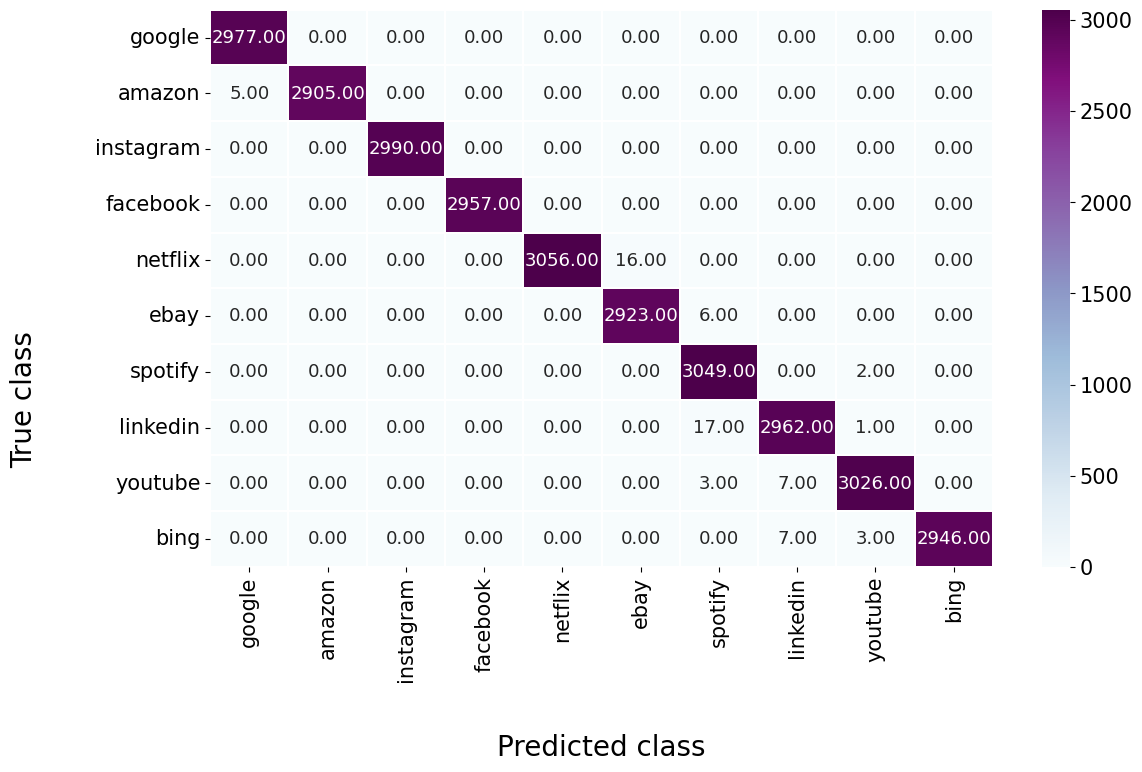

In [38]:
#i had a problem with the code, with search i got to chaging the dataset into rdd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(y_pred['prediction',"WebService"].rdd)
cm = metrics.confusionMatrix().toArray()
#REPLACE NAME OF YOUR DATAFRAME HERE
classes = selected_df.select("class:207").distinct().rdd.map(lambda r: r[0]).collect()
classes = [el.replace("class:", "") for el in classes]
fig, ax = plt.subplots(figsize =(12, 8))
fontsize = 15
ax = sns.heatmap(cm, xticklabels=classes, yticklabels=classes, linewidth = 0.2,
cmap="BuPu", annot = True, fmt = ".2f", annot_kws={"fontsize":fontsize-2})
cbar = ax.collections[0].colorbar 
cbar.ax.tick_params(labelsize=fontsize) 
ax.figure.axes[-1].yaxis.label.set_size(fontsize+5) 
ax.figure.axes[-1].yaxis.set_label_coords(3,.5) 
ax.set_xticklabels(classes, fontsize=fontsize, rotation = 90) 
ax.set_yticklabels(classes, fontsize=fontsize, rotation = 0) 
ax.set_ylabel("True class", fontsize = fontsize + 5) 
ax.set_xlabel("Predicted class", fontsize = fontsize + 5) 
ax.yaxis.set_label_coords(-.22,.3) 
ax.xaxis.set_label_coords(.5, -.3)
plt.tight_layout()
plt.show()

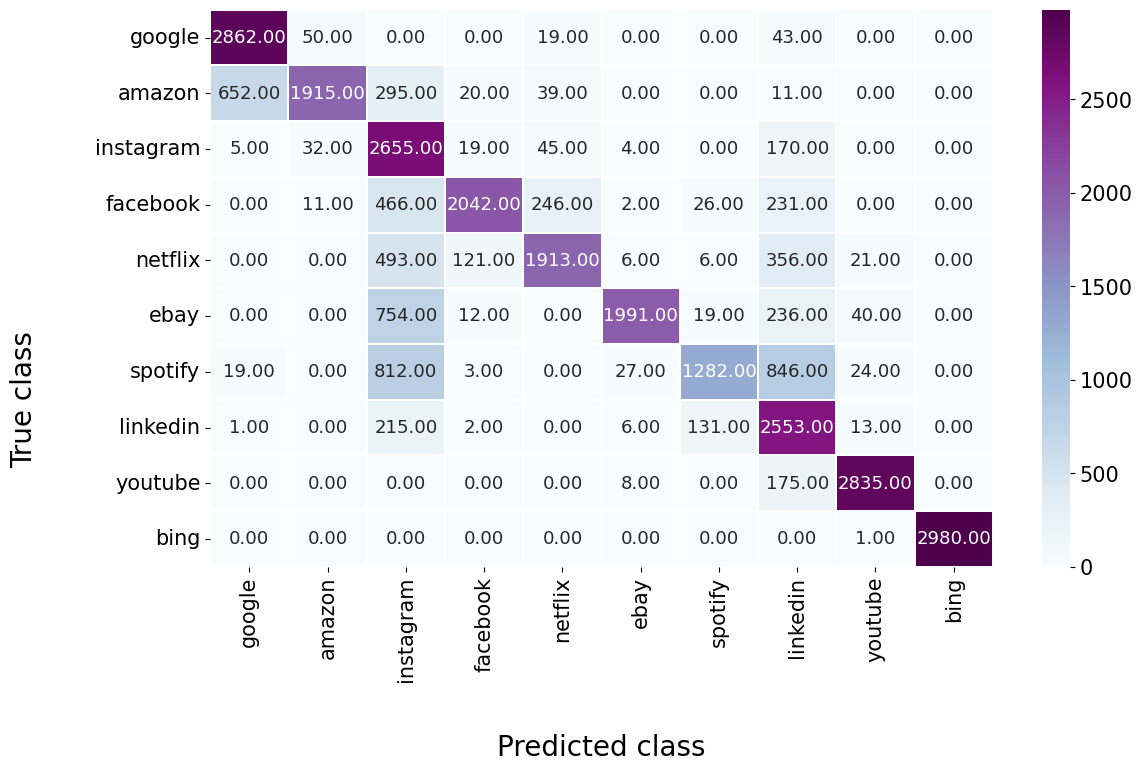

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(rf_pred['prediction',"WebService"].rdd)
cm = metrics.confusionMatrix().toArray()
#REPLACE NAME OF YOUR DATAFRAME HERE
classes = selected_df.select("class:207").distinct().rdd.map(lambda r: r[0]).collect()
classes = [el.replace("class:", "") for el in classes]
fig, ax = plt.subplots(figsize =(12, 8))
fontsize = 15
ax = sns.heatmap(cm, xticklabels=classes, yticklabels=classes, linewidth = 0.2,
cmap="BuPu", annot = True, fmt = ".2f", annot_kws={"fontsize":fontsize-2})
cbar = ax.collections[0].colorbar 
cbar.ax.tick_params(labelsize=fontsize) 
ax.figure.axes[-1].yaxis.label.set_size(fontsize+5) 
ax.figure.axes[-1].yaxis.set_label_coords(3,.5) 
ax.set_xticklabels(classes, fontsize=fontsize, rotation = 90) 
ax.set_yticklabels(classes, fontsize=fontsize, rotation = 0) 
ax.set_ylabel("True class", fontsize = fontsize + 5) 
ax.set_xlabel("Predicted class", fontsize = fontsize + 5) 
ax.yaxis.set_label_coords(-.22,.3) 
ax.xaxis.set_label_coords(.5, -.3)
plt.tight_layout()
plt.show()

## 2.5.1

## 2.5.2

# 2.6.1
### Parameter Tuning

In [39]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np

In [43]:
# tuning the parameters to minimize the loss function
# according to the docs 
# https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html
# maxDepth = max number of levels in each decision tree
# A node is 100% impure when a node is split evenly 50/50 and 100% pure when all of its data belongs to a single class.
rf = RandomForestClassifier(labelCol='WebService', featuresCol='features', numTrees=20)
paramGrid = ParamGridBuilder()\
                    .addGrid(rf.numTrees, [10,20]) \
                    .addGrid(rf.maxDepth, [5,10]) \
                    .addGrid(rf.impurity, ["Gini","Entropy"])\
                    .build()

In [44]:
# folds: number of subsets
# using crossvalidation
myEvaluator = MulticlassClassificationEvaluator(labelCol='WebService',predictionCol='prediction',metricName='accuracy')
cv=CrossValidator(estimator=rf,evaluator=myEvaluator,estimatorParamMaps=paramGrid, numFolds=3)
cvModelRf=cv.fit(train_df)

In [45]:
cvRfResult = cvModelRf.transform(test_df)

In [46]:
print( multi_eval.evaluate(cvRfResult))

[Stage 1420:>                                                       (0 + 2) / 2]

0.9996638768444758


In [47]:
# as it can be seen accuracy became much better and was improved from 0.7767 to 0.9996

In [49]:
cvModelRf.getEstimatorParamMaps()[np.argmax(cvModelRf.avgMetrics)]

{Param(parent='RandomForestClassifier_fc122e8fb750', name='numTrees', doc='Number of trees to train (>= 1).'): 20,
 Param(parent='RandomForestClassifier_fc122e8fb750', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10,
 Param(parent='RandomForestClassifier_fc122e8fb750', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'Entropy'}

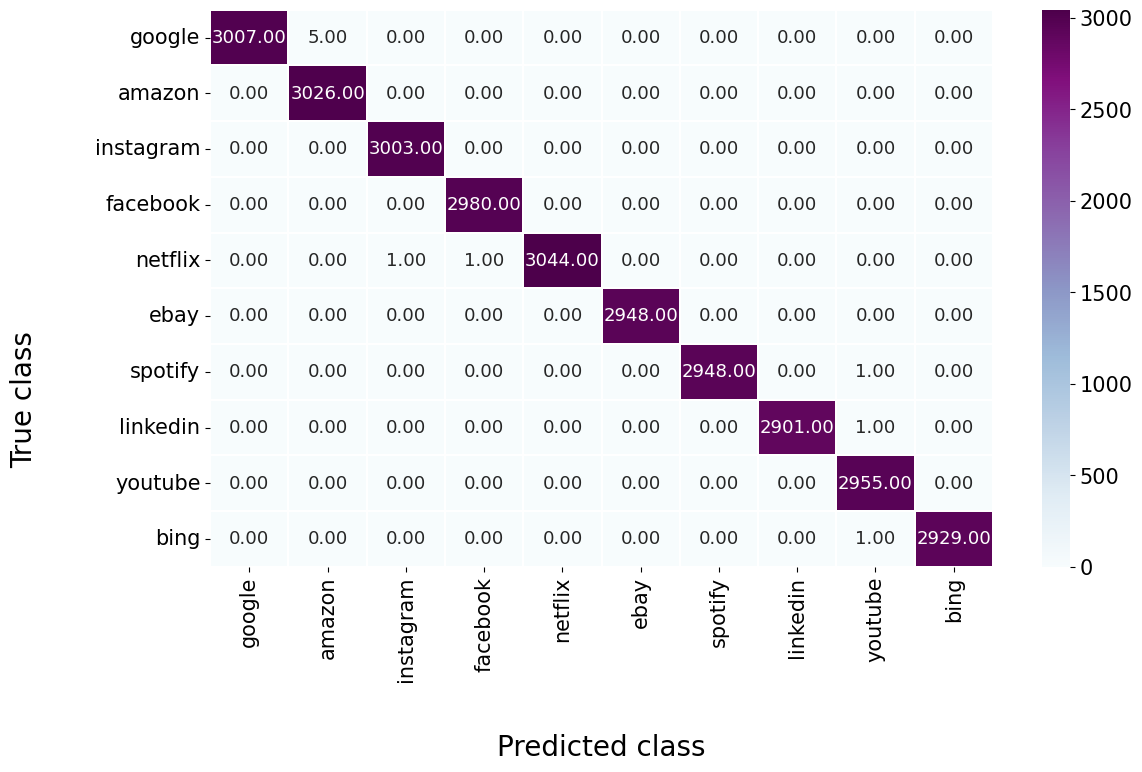

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(cvRfResult['prediction',"WebService"].rdd)
cm = metrics.confusionMatrix().toArray()
#REPLACE NAME OF YOUR DATAFRAME HERE
classes = selected_df.select("class:207").distinct().rdd.map(lambda r: r[0]).collect()
classes = [el.replace("class:", "") for el in classes]
fig, ax = plt.subplots(figsize =(12, 8))
fontsize = 15
ax = sns.heatmap(cm, xticklabels=classes, yticklabels=classes, linewidth = 0.2,
cmap="BuPu", annot = True, fmt = ".2f", annot_kws={"fontsize":fontsize-2})
cbar = ax.collections[0].colorbar 
cbar.ax.tick_params(labelsize=fontsize) 
ax.figure.axes[-1].yaxis.label.set_size(fontsize+5) 
ax.figure.axes[-1].yaxis.set_label_coords(3,.5) 
ax.set_xticklabels(classes, fontsize=fontsize, rotation = 90) 
ax.set_yticklabels(classes, fontsize=fontsize, rotation = 0) 
ax.set_ylabel("True class", fontsize = fontsize + 5) 
ax.set_xlabel("Predicted class", fontsize = fontsize + 5) 
ax.yaxis.set_label_coords(-.22,.3) 
ax.xaxis.set_label_coords(.5, -.3)
plt.tight_layout()
plt.show()